## AIM: Further processing of the Fangraphs data to ensure it is in a place that it can be used for my downstream applications.

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv('Master_df.csv', index_col = 0)

In [15]:
df.head()

,Season,Name,Team,W,L,SV,G,GS,IP,K/9,...,WHIP,IP/G,Shannon Diversity,Strikeouts,Control,Stamina/Consistency,BA Against,Velocity,Ground Balls,Pitch Diversity
0,2002,A.J. Burnett,NaN,12,9,0,29,29,201.2,8.70,...,1.17,6.95,0.753311,90.789474,36.348684,97.203947,88.322368,100.000000,57.236842,15.460526
1,2003,A.J. Burnett,NaN,0,2,0,4,4,23.0,8.22,...,1.57,5.75,0.772823,91.118421,6.250000,61.019737,85.032895,97.861842,89.144737,7.894737
2,2004,A.J. Burnett,NaN,7,6,0,19,19,118.0,8.31,...,1.18,6.21,0.812509,89.455782,66.666667,83.333333,64.115646,100.000000,81.122449,10.884354
3,2005,A.J. Burnett,NaN,12,12,0,32,32,209.0,8.53,...,1.26,6.53,0.885130,92.395437,38.022814,87.452471,41.825095,99.239544,95.057034,20.152091
4,2006,A.J. Burnett,NaN,10,8,0,21,21,135.2,7.83,...,1.30,6.46,0.759964,83.222591,74.418605,89.700997,39.368771,98.671096,85.215947,6.976744


In [16]:
# SAVES are a relief/closing pitcher metric as it is for end of games
# My project focuses on STARTING pitchers, so saves are not relevant
df.drop(['SV'], axis=1, inplace=True)

In [17]:
# Rename column to just Stamina for simplicity
df.rename({'Stamina/Consistency':'Stamina'}, axis=1, inplace= True)
# df.to_csv('Master_df.csv')

In [18]:
# 1520 unique pitchers
len(pd.unique(df['Name']))

1520

In [22]:
# I want to calculate a cumulative sum of inherent attributes as a measure of player physical performance

# Pull out just my metrics of interest
metrics = df.loc[:,'Shannon Diversity':'Pitch Diversity']

# Drop the non standardized Shannon Diversity Columns
# Also drop the BA Against column, I feel it's not as much of an inherent attribute of a pitcher
# I now have 6 attributes of interest
metrics.drop(['Shannon Diversity', 'BA Against'], axis=1, inplace=True)

# Get a sum of all their attributes
metrics['performance'] = metrics.sum(axis=1)
metrics

,Strikeouts,Control,Stamina,Velocity,Ground Balls,Pitch Diversity,performance
0,90.789474,36.348684,97.203947,100.000000,57.236842,15.460526,397.039474
1,91.118421,6.250000,61.019737,97.861842,89.144737,7.894737,353.289474
2,89.455782,66.666667,83.333333,100.000000,81.122449,10.884354,431.462585
3,92.395437,38.022814,87.452471,99.239544,95.057034,20.152091,432.319392
4,83.222591,74.418605,89.700997,98.671096,85.215947,6.976744,438.205980
...,...,...,...,...,...,...,...
5437,70.793651,22.857143,39.523810,87.777778,72.857143,41.904762,335.714286
5438,67.201166,65.597668,98.250729,95.335277,57.871720,77.259475,461.516035
5439,62.228261,76.902174,97.146739,96.603261,57.608696,69.021739,459.510870
5440,19.087838,65.033784,5.236486,44.425676,45.945946,25.675676,205.405405


In [23]:
# Copy over the performance column to the main dataframe
df['performance'] = metrics['performance'].copy()

In [24]:
# Save
df.to_csv('Master_df.csv')

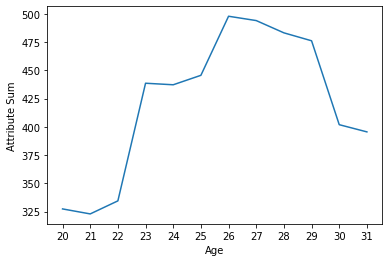

In [27]:
# Quick and dirty plot of physical attribute sum over time for a player
kershaw = df[df['Name'] == 'Clayton Kershaw']
kershaw.reset_index(drop = True, inplace = True)
plt.plot(kershaw['Age'], kershaw['performance'])
plt.xticks(np.arange(kershaw['Age'].min(), kershaw['Age'].max()+1,1))
plt.xlabel('Age')
plt.ylabel('Attribute Sum')
plt.show()

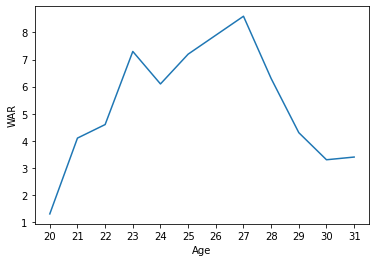

In [28]:
# Similar quick and dirty plot for WAR over career
# War is an on-field performance metric for pitchers, I want to quickly see how it correlates to performance/attribute sum
plt.plot(kershaw['Age'], kershaw['WAR'])
plt.xticks(np.arange(kershaw['Age'].min(), kershaw['Age'].max()+1,1))
plt.xlabel('Age')
plt.ylabel('WAR')
plt.show()

In [29]:
# Create a new column that show the percent change of performance Y/Y
kershaw['delta'] = kershaw['performance'].pct_change()
kershaw['delta']

<ipython-input-29-4facbe2dd325>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kershaw['delta'] = kershaw['performance'].pct_change()


0          NaN
1    -0.013525
2     0.035792
3     0.311485
4    -0.003113
5     0.019144
6     0.117403
7    -0.007701
8    -0.021987
9    -0.014559
10   -0.156020
11   -0.015872
Name: delta, dtype: float64

***
For every player, there is a physical peak. I want to be able to calculate and denote what year(s) they were at their physical peak.

I define physical peak as the age at which they reach their maximum `performance` (ie. max of physical attribute sums). As players age, their traits change. Some will increase and others will decrease to compensate. However traits such as stamina, velocity and correspondingly, strikeouts, will decrease at a faster rate than other traits such as control and diversity will increase to compensate. 

Therefore, there will still likely be a net percentage decrease in the physical attribute sum denoted by `performance` that can be detected as the decline from their peak.

To accomodate for season/season fluctuations, I will define the end of their peak as a 10% decrease in `performance` relative to the previous year. Any seasons between their peak and their decline will still be denoted as years that are part of their physical peak. 

A limitation to this is that players who experience very slow but steady declines from their peak (ex. consistent 5% Y/Y decline) will not be detected. This is something I will definitely look into improving and finding a solution for. 

For now, I know that anecdotally, atheletes generally do not experience slow and steady declines, but a player's decline is usually sharp and sudden.

In [32]:
# Create an empty list to store their prime years
prime = []
# Iterate through all entries for a player
for i in range(len(kershaw)):
    # Start appending years to the list of prime years when their performance equals their career max
    if kershaw.loc[i, 'performance'] == kershaw['performance'].max():
        prime.append(kershaw.loc[i, 'Age'])
        # For any year after that, if the decline in performance is not a greater than -10% decline then append that year
        for j in range(1, len(kershaw) - i):
            if kershaw.loc[i+j, 'delta'] > -0.1:
                prime.append(kershaw.loc[i+j, 'Age'])
            # If there is a greater than 10% decline in performance, terminate the loop
            elif kershaw.loc[i+j, 'delta'] <= -0.1:
                break

prime

[26, 27, 28, 29]

In [33]:
# Transform the above code to a function so that it can be scaled for any player of interest
def prime(name):
    kershaw = df[df['Name'] == name]
    kershaw.reset_index(drop = True, inplace = True)
    kershaw['delta'] = kershaw['performance'].pct_change()

    years = []
    for i in range(len(kershaw)):
        if kershaw.loc[i, 'performance'] == kershaw['performance'].max():
            years.append(kershaw.loc[i, 'Age'])
            for j in range(1, len(kershaw) - i):
                if kershaw.loc[i+j, 'delta'] > -0.1:
                    years.append(kershaw.loc[i+j, 'Age'])
                elif kershaw.loc[i+j, 'delta'] <= -0.1:
                    break
    # Add a string so that it returns more than just a list but rather, a coherent sentence
    s = 'Prime Years: '
    # Add each year to the string separated by a comma and space
    for yr in years:
        s = s + str(yr) + ', '
    # Remove the last comma and space
    s = s.rstrip(', ')
    return s

In [34]:
# Test with another player
prime('Zack Greinke')

<ipython-input-33-81a1834515b5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kershaw['delta'] = kershaw['performance'].pct_change()


'Prime Years: 28, 29, 30, 31'

Great! This function works and can be deployed later in my final product!

***